# Time Series using ARIMA models

In this notebook, we analyse a stock ('SAIL') from the Indian stock exchange. Perform exploratory data analysis using distribution, QQ and Boxplots. 

We also check if the time series is stationery or not and plot the ACF and PACF plots to identify the process. Having a stationery time series helps us to perform further analyis and apply machine learning techniques over the same. Since our time series is not stationery we will convert it via differencing.

In [71]:
##Install if you do not have them

#!pip install pmdarima
#!pip install tsfresh

In [119]:
#Importe the necessary modules

import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot as qq
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import KFold, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, TimeSeriesSplit
import math
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We will use the yahoo finance api to download the stock data over 8 years. Yahoo finance is free and has numerous features to extract the security prices, its fundamentals and accessible to everyone.

In [120]:
sail = yf.download('SAIL.NS', period= "8y")

[*********************100%***********************]  1 of 1 completed


As per the Investopedia, closing price is the raw price - the last transacted value before the market closes on a particular day. Adjusted closing price is the adjusted Coroporate Actions on Closing Price

Here we plot the adjusted closing price of the security over past 8 years. You can similarly choose a different security by entering a different ticker in the yahoo finance api. (More information here: https://pypi.org/project/yfinance/)

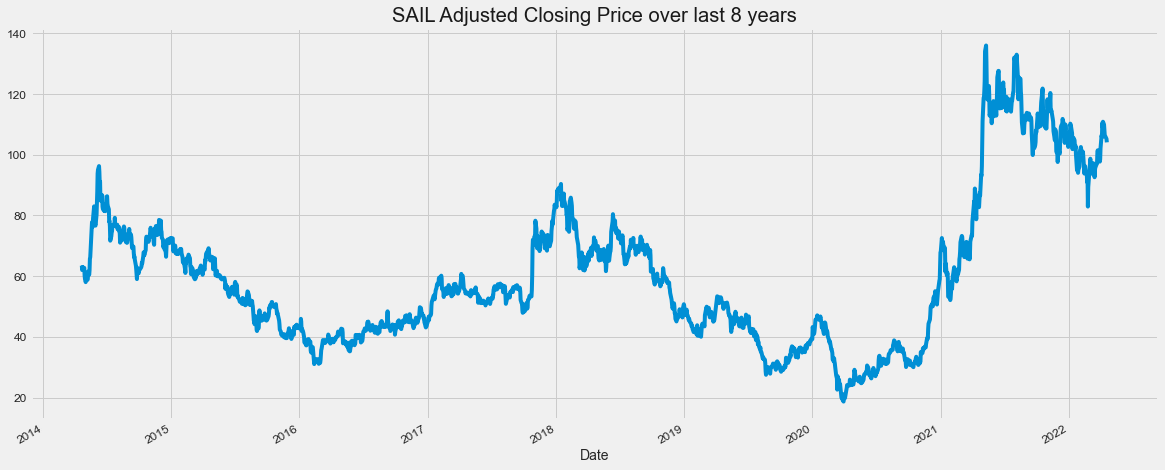

In [121]:
sail['Adj Close'].plot()
plt.title('SAIL Adjusted Closing Price over last 8 years')
plt.show()

In [122]:
sail['Date'] = sail.index
sail['Date'] = pd.to_datetime(sail['Date'],format='%Y-%m-%d')
sail.head()

,Open,High,Low,Close,Adj Close,Volume,Date
Date,,,,,,,
2014-04-21,71.550003,73.349998,71.349998,72.449997,63.465637,23661960,2014-04-21
2014-04-22,72.750000,72.750000,70.250000,70.800003,62.020248,22023725,2014-04-22
2014-04-23,70.750000,72.449997,70.699997,71.900002,62.983852,39971910,2014-04-23
2014-04-24,71.900002,71.900002,71.900002,71.900002,62.983852,0,2014-04-24
2014-04-25,71.900002,73.400002,70.099998,71.349998,62.502045,29331610,2014-04-25


In [123]:
feature_selected = sail.drop(axis=1, labels= ['Open', 'High', 'Low', 'Close', 'Volume'])
col_order = ['Date', 'Adj Close']

#taking only the 2 columns
new_data = feature_selected.reindex(columns=col_order)

#Resampling to take the monthly mean of the stock price of SAIL since 2014
new_data.head()
monthly = new_data['Adj Close'].resample('M').mean()
monthly = monthly.to_frame()

# EDA

In [124]:
monthly['Year'] = monthly.index.year
monthly['Month'] = monthly.index.strftime('%B')
monthly['dayofweek'] = monthly.index.strftime('%A')
monthly['quarter'] = monthly.index.quarter

#monthly.loc['Month':'April', 'Year':2022]
monthly.head()

,Adj Close,Year,Month,dayofweek,quarter
Date,,,,,
2014-04-30,61.981929,2014,April,Wednesday,2
2014-05-31,69.597589,2014,May,Saturday,2
2014-06-30,86.439586,2014,June,Monday,2
2014-07-31,78.062862,2014,July,Thursday,3
2014-08-31,73.712451,2014,August,Sunday,3


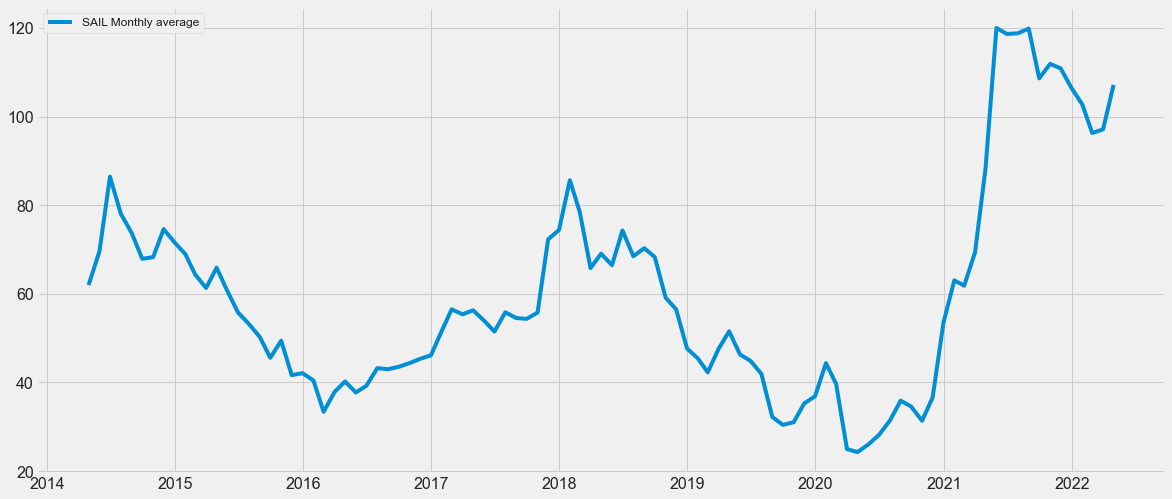

In [125]:
fig =plt.figure(figsize=(18,8))
plt.plot(monthly['Adj Close'], label = 'SAIL Monthly average')
plt.style.use('fivethirtyeight')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#ax.set_title('Monthly Resampled')
plt.legend(prop={'size':12})
plt.show()

(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  , 0.0225]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

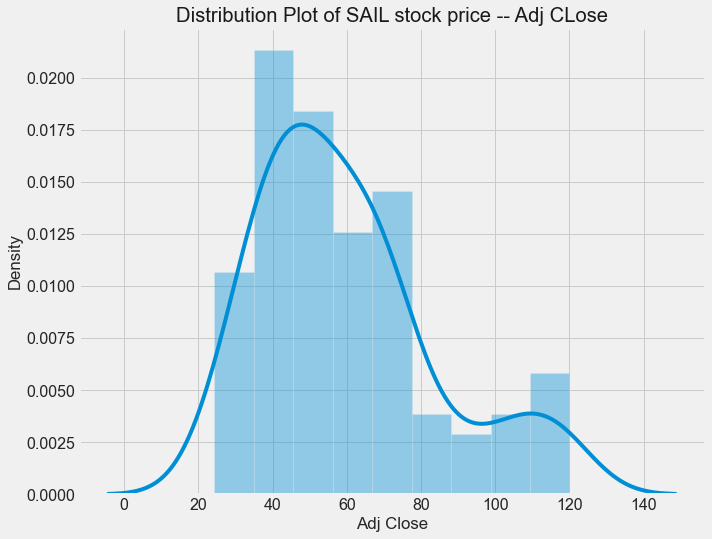

In [126]:
fig = plt.figure(figsize=(10,8))
sns.distplot(monthly['Adj Close']).set_title('Distribution Plot of SAIL stock price -- Adj CLose')
ax.tick_params(labelsize=12)
sns.set(font_scale=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

Our distriution is right skewed

Text(0.5, 1.0, 'Box Plot of SAIL--Adj Closing')

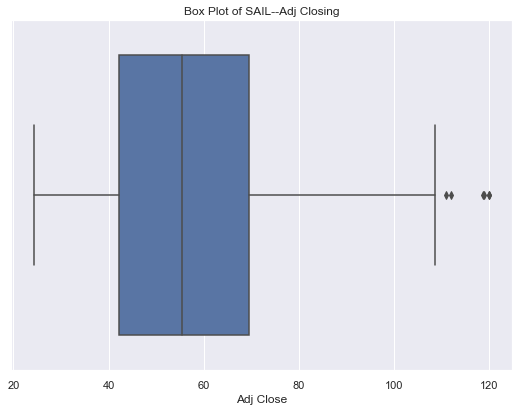

In [127]:
fig=plt.figure(figsize=(8,6))
sns.boxplot(monthly['Adj Close']).set_title('Box Plot of SAIL--Adj Closing')

Distrubition shows right skewed. We also have a few outliers on the right side of 100

Text(0.5, 1.0, 'QQ Plot of the Stock Price')

<Figure size 864x864 with 0 Axes>

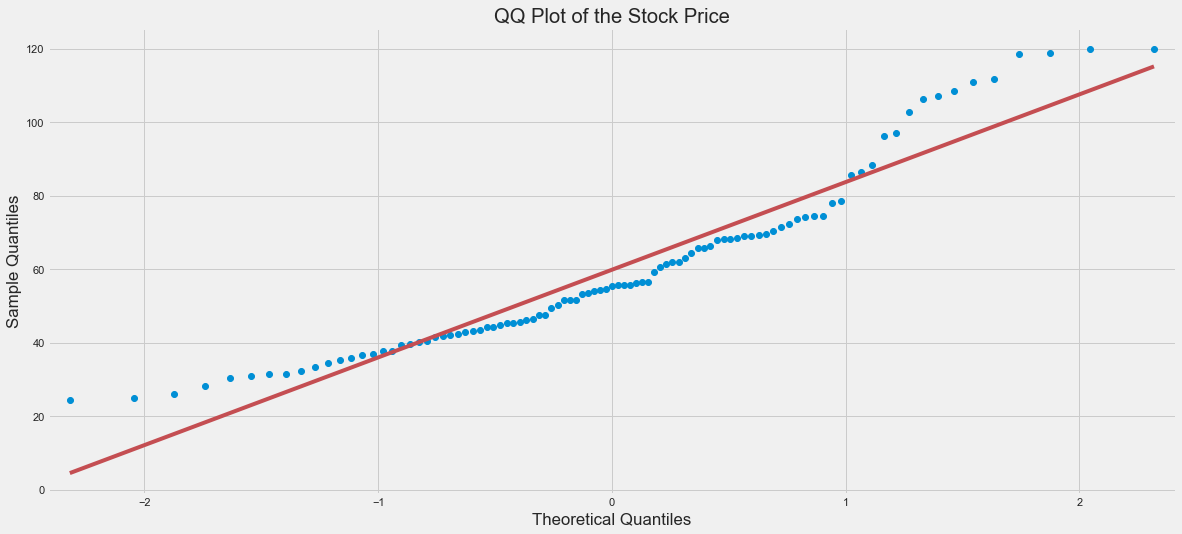

In [136]:
fig=plt.figure(figsize=(12,12))
qq_plot = qq(monthly['Adj Close'],line='s')
plt.title('QQ Plot of the Stock Price')

Shows distribution does not follow Gaussian Normal Distribution. Also shows extent of skewness on both left and right side

<module 'matplotlib.style' from 'D:\\anaconda\\lib\\site-packages\\matplotlib\\style\\__init__.py'>

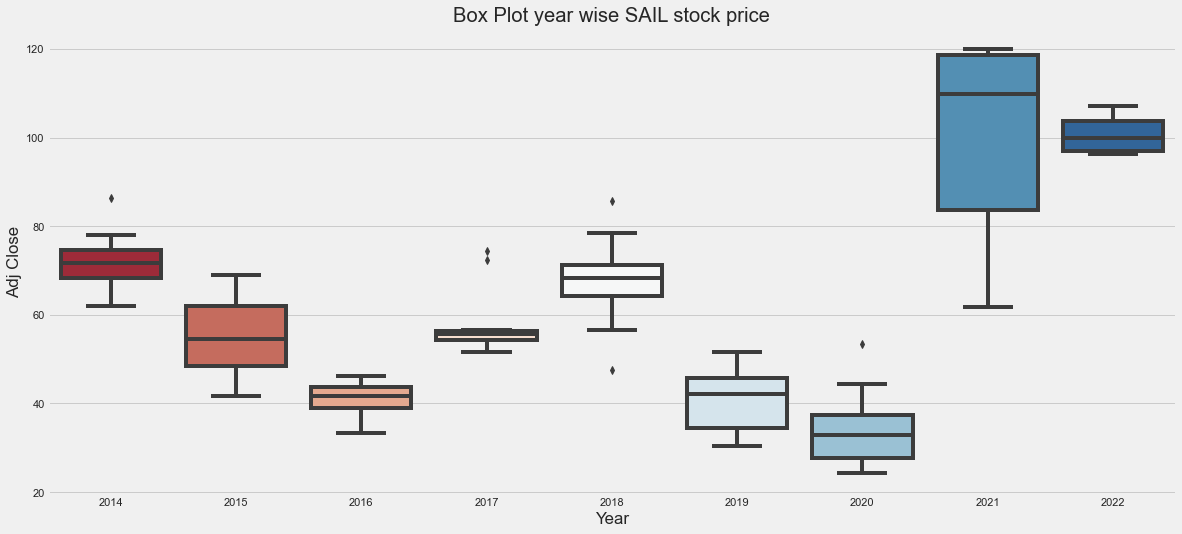

In [137]:
ax = sns.boxplot(x= monthly['Year'], y=monthly['Adj Close'], palette = 'RdBu')
ax.set_title('Box Plot year wise SAIL stock price')
plt.style

Outliers can been seen in the years 2014, 2017, 2018 and 2020. Similarly, we can see a huge rise in the year 2021 and it also has a lot of variability in the stock price. Could be a bounce back a year after the Covid Pandemic, but the prices are high comparatively to the past few years

# Decomposition of the Time Series

Now, we will decompose the trend and seasonality and notice the stock price.

<Figure size 1440x1152 with 0 Axes>

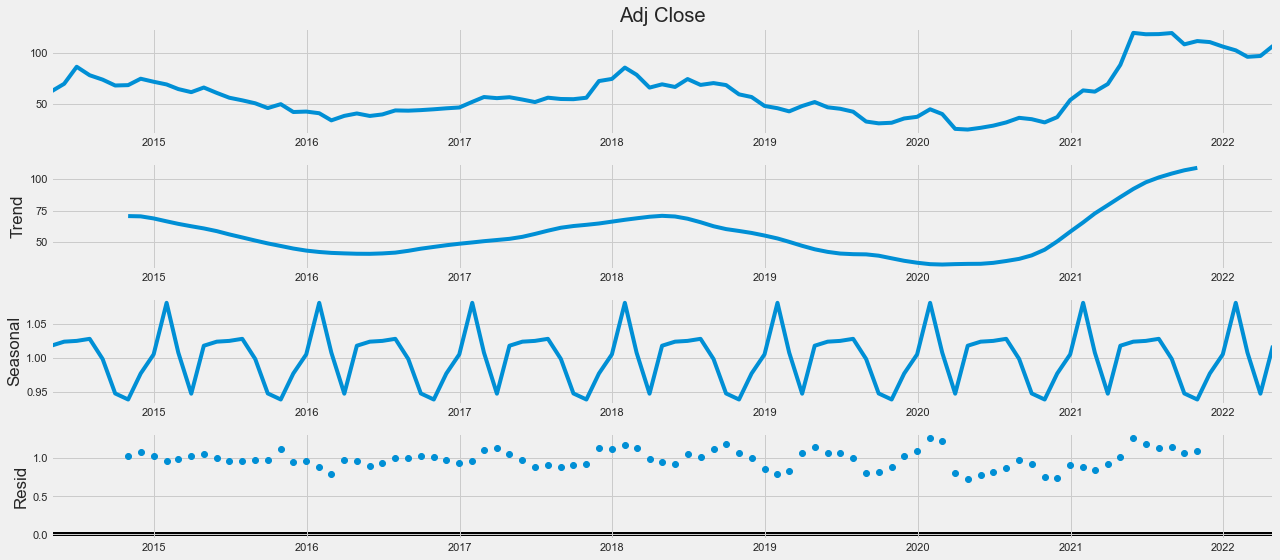

In [138]:
rcParams['figure.figsize']=18,8
plt.figure(figsize=(20,16))
decomposed_series = sd(monthly['Adj Close'], model = 'multiplicative', period = 12)
decomposed_series.plot()
plt.show()

The residual is what's left over after trends and seasonality are removed. Time series models assume that the data is stationary and only the residual component satisfies the conditions for stationarity. Residuals are random fluctuations. You can think of them as a noise component.

Pre-Pandemic levels seasonality.

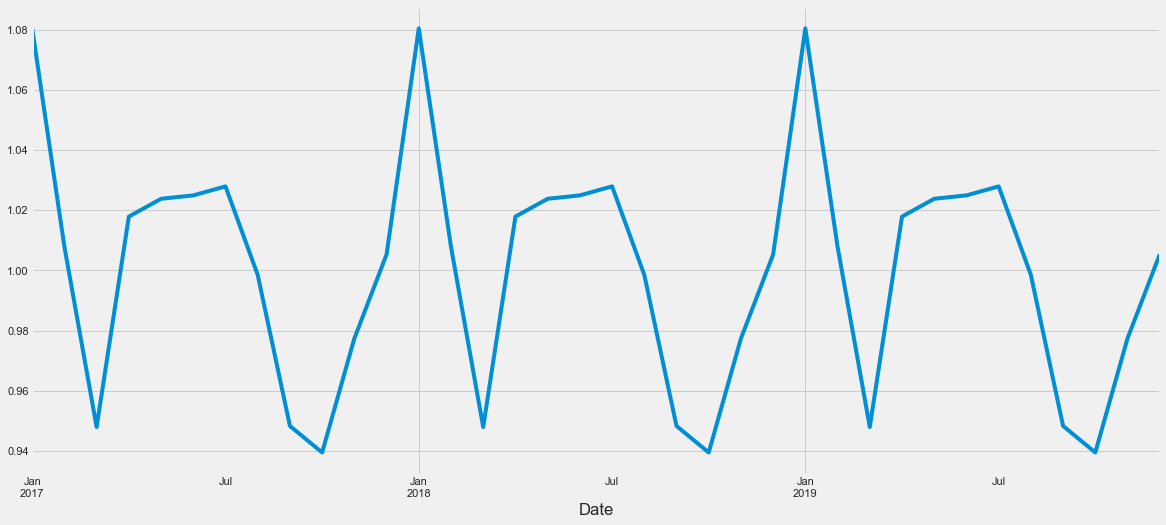

In [139]:
decomposed_series.seasonal['2017':'2019'].plot()
plt.show()


We notice that the stock is always on the rise at the start of the year. When you consider the prices even after the pandemic, the behaviour is the same. 

Pandemic and post-pandemic levels

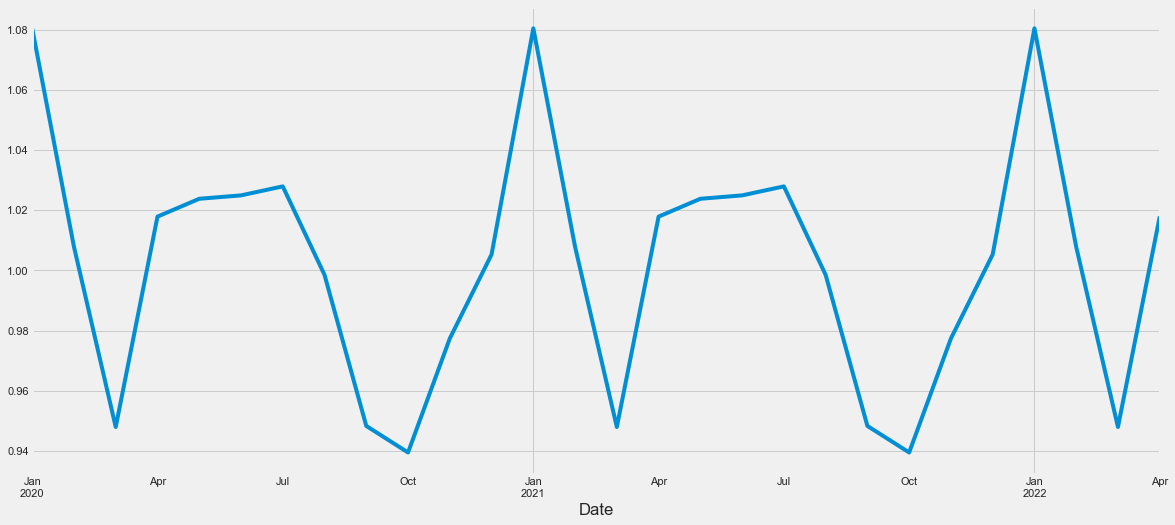

In [140]:
decomposed_series.seasonal['2020':'2022'].plot()
plt.show()

As we can see from the series, 

Trend: An upward trend overall.
Seasonality: It appears to be rallying at the start of the year always, irrespective of the pandemic situation.  

# Stationarity test

Null Hypothesis : Time series has a unit root -It is non-stationary

Alternate Hypothesis : Time series does not have a unit root -It is stationary

Time Series is Stationary if we have constant mean,constant variance and No Trend and Seasonality.

In [134]:
x = monthly['Adj Close']
result = adfuller(x, autolag = 'AIC')
adf_results = pd.Series(result[0:4], index = ['ADF Statistic', 'p-value', 'No. of lags used', 'No. of observations'])
for key,value in result[4].items():
    adf_results['Critical value (%s)' %key] = value
print(adf_results)

ADF Statistic           -1.246536
p-value                  0.653264
No. of lags used         1.000000
No. of observations     95.000000
Critical value (1%)     -3.501137
Critical value (5%)     -2.892480
Critical value (10%)    -2.583275
dtype: float64


Failed to reject the null hypothesis. Time series is not stationary. Also, we saw from above, Trend and Seasonality are also present.

AutoCorelation Function (ACF) now Corellogram

We will plo

Text(0.5, 0, 'Lags')

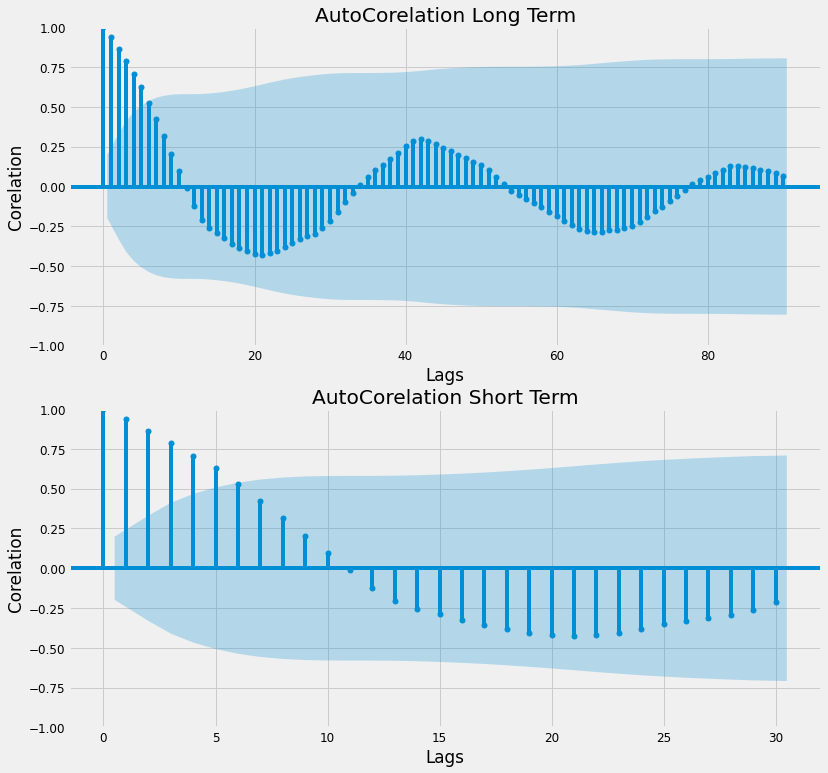

In [41]:
fig, (ax1,ax2) = plt.subplots(2, figsize = (12,12))
acf = plot_acf(monthly['Adj Close'], lags = 90, ax = ax1)
ax1.set_title('AutoCorelation Long Term')

acf = plot_acf(monthly['Adj Close'], lags = 30, ax = ax2)
ax2.set_title('AutoCorelation Short Term')

ax1.set_ylabel('Corelation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Corelation')
ax2.set_xlabel('Lags')

Gradual decrease in the values indicate future values are heavily dependent on the lagged values. This shows that the series is not random and good for time series modelling. Also a non-stationary time series.

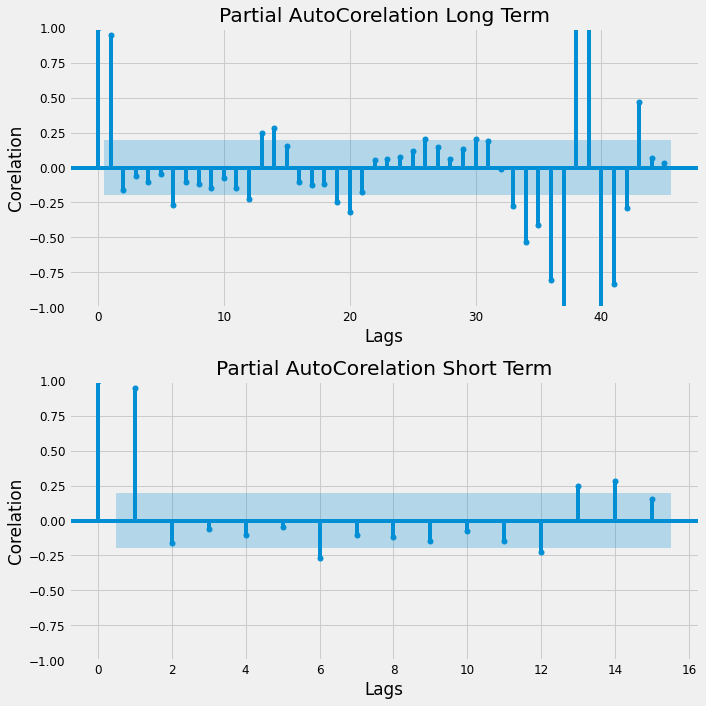

In [42]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
pacf = plot_pacf(monthly['Adj Close'], lags = 45, ax = ax1)
ax1.set_title("Partial AutoCorelation Long Term")

pacf = plot_pacf(monthly['Adj Close'], lags = 15, ax = ax2)
ax2.set_title('Partial AutoCorelation Short Term')

ax1.set_xlabel('Lags')
ax1.set_ylabel('Corelation')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Corelation')

plt.tight_layout(pad = 1)

We will make a few transformations to make the time series stationery. We will use the differencing technique. More: (https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)

In [43]:
monthly_diff = monthly['Adj Close'] - monthly['Adj Close'].shift(1)

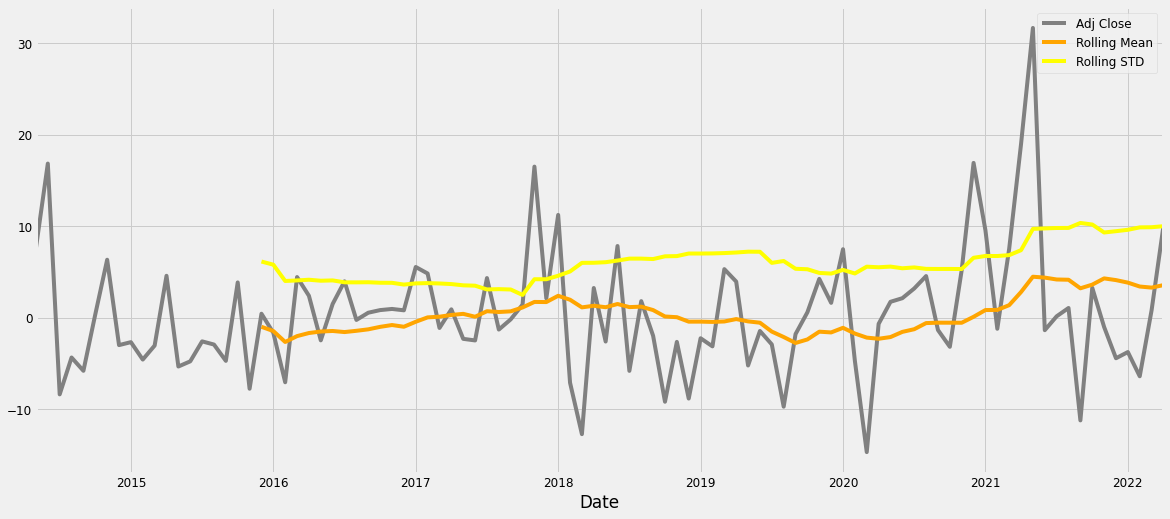

In [44]:
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [45]:
def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
      print('\t%s: %.3f' % (key, value))
 
  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis(Ho)-Time Series is Stationary')
  else:
    print('Failed to Reject Ho-Time Series is Non-Stationary')
    

In [46]:
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -7.422749
p-value: 0.000000
Critical Values:
	1%: -3.501
	5%: -2.892
	10%: -2.583
Reject Null Hypothesis(Ho)-Time Series is Stationary


Now, the time series is stationery. And we can check it with the ACF and PACF

Text(0, 0.5, 'Corelation')

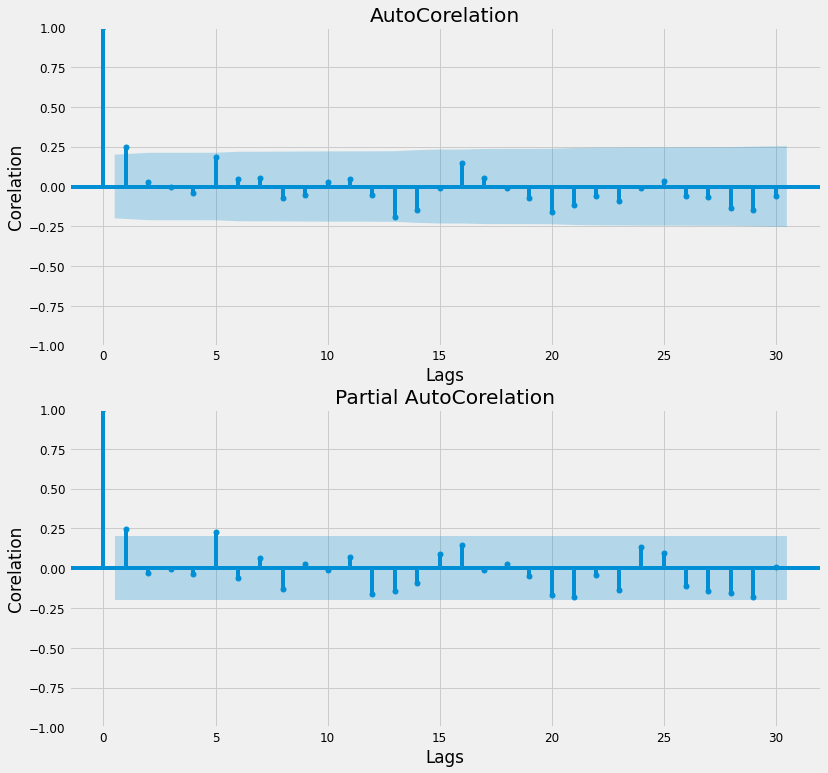

In [47]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12,12))
acf = plot_acf(monthly_diff[1:], lags = 30, ax = ax1)
pacf = plot_pacf(monthly_diff[1:], lags = 30, ax = ax2)

ax1.set_title('AutoCorelation')
ax2.set_title('Partial AutoCorelation')

ax1.set_xlabel('Lags')
ax1.set_ylabel('Corelation')
ax2.set_xlabel('Lags')
ax2.set_ylabel('Corelation')

As per the plots above, we can confirm that the time series is stationery and differencing indeed has made it happen. The values do not show much difference from zero between the lags. 

# ARIMA Modelling

In [88]:
series = monthly['Adj Close']

train, test = split(series, train_size=0.6, shuffle=False)

In [89]:
print('Train',len(train))
print('Test',len(test))

Train 58
Test 39


In [58]:
train.head()

Date
2014-04-30    61.981931
2014-05-31    69.597592
2014-06-30    86.439586
2014-07-31    78.062862
2014-08-31    73.712450
Freq: M, Name: Adj Close, dtype: float64

In [90]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of grid search Model parameter combinations for Seasonal-ARIMA')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

Examples of grid search Model parameter combinations for Seasonal-ARIMA
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


# Hyper parameter tuning

In [91]:
#list_param = []
#list_param_seasonal=[]
list_results_aic=[]
combs = {}
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=True)

            model = model.fit(disp=False)

            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            combs.update({model.aic : [param, param_seasonal]})
            #list_param.append(param)
            #list_param_seasonal.append(param_seasonal)
            list_results_aic.append(model.aic)
        except:
            continue
            
best_aic = min(list_results_aic)

In [92]:
print('best aic is: ', round(best_aic, 3))
print(40*'==')
print ('ARIMA parameters: ', '\n', 'AR: ', combs[best_aic][0][0], '\n', 'I: ',combs[best_aic][0][1], '\n', 'MA: ',combs[best_aic][0][2])
print('Seasonal parameters:', combs[best_aic][1])

best aic is:  12.0
ARIMA parameters:  
 AR:  2 
 I:  0 
 MA:  1
Seasonal parameters: (1, 0, 1, 12)


In [94]:
mod = sm.tsa.statespace.SARIMAX(train,
                                order=(2, 0, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

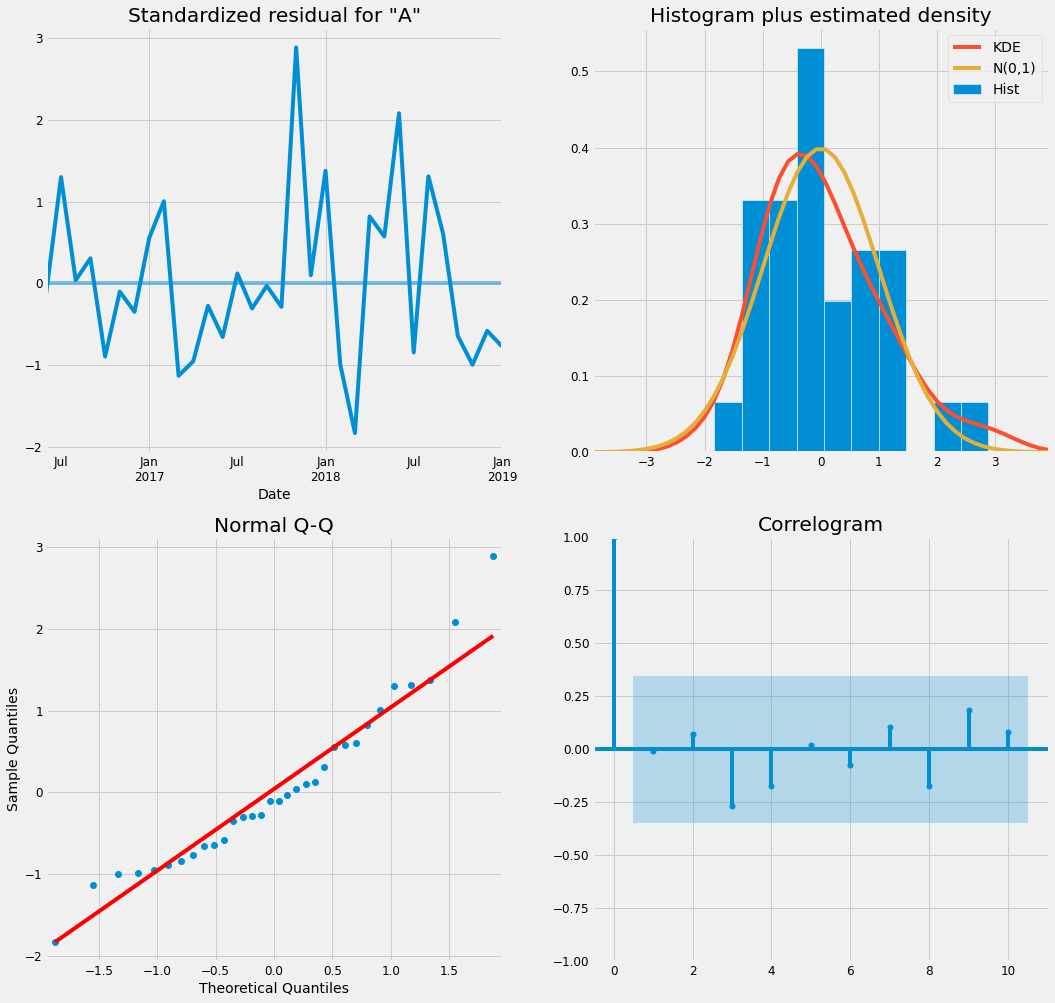

In [103]:
results.plot_diagnostics(figsize=(16, 16))
plt.show()

Few inferences from the residual analysis:

The distribution plot now follows a normal distribution and so does the QQ plot. The Correlogram does not show corelation between points, indicating the points are uncorelated and not dependant as before it was converterd to stationary. It would be right to believe that the model has now captured the pricing of the stock in a good manner.